## Code demonstration for using *beamline* python package to do online modeling

                                        Tong Zhang, March, 2016 (draft)
    
For example, define lattice configuration for a 4-dipole chicane with quads:
                    
                    |-|---|-|  
                    /       \
          ---||---|-|       |-|---||---

        i.e.   drift + quad  + drift 
            + dipole + drift + dipole + drift 
            + dipole + drift + dipole
            + drift  + quad  + drift

Below is the typical workflow and interleaved comments.

In [1]:
import beamline
import os

### Section 1: Magnetic Elements Modeling

The very first step need to push forward is to correctly model the physical elements (one by one), in the *beamline* package, magnet components classes could be found in *element* module, e.g. quadrupole is abstracted in *ElementQuad* class, charge is in *ElementCharge*, etc., they are all inherited from *MagBlock*.

The common or shared information/configuration for all these elements could be predefined in *MagBlock* class, e.g. we can put information like facility name, time stamp, author, etc., common information is presumed not changed, so please defined in the first step (see STEP 1).

To set the elements' configuration, method *setConf(config, type)* could be used to, in which 'config' is either configuration string with the format like "k1=10.0,l=0.1" or python dictionary like "{'k1': 10.0, 'l': 0.1}", and 'type' is the configuration type to be confiugred, could be 'comm' [common configuration], 'ctrl' [control configuration], 'simu' [simulation configuration], 'misc' [miscellaneous configuration] and 'all' [all configurations].s

The unit between EPICS PV values and real physical variables usually are required to do conversions, so in the design stage, the method *unitTrans(inval,direction = '+',transfun = None)* is created for handling this issue. One can define this conversion function at the class stage, but this approach is limited to the case that all the elements with the same type only with the same conversion function, which is not proper in the real situation. Thus, *transfun* is created as the input parameter for *unitTrans* method, which is a user-defined function for each element object.

#### STEP 1: define common information

In [2]:
#commdinfo = {'DATE': '2016-03-22', 'AUTHOR': 'Tong Zhang'}
comminfo = 'DATE = 2016-03-24, AUTHOR = Tong Zhang'
beamline.MagBlock.setCommInfo(comminfo)

#### STEP 2: create elements

In [3]:
# charge, this is visual element for the real accelerator, but is a must for elegant tracking
chconf = {'total':1e-9}
q = beamline.ElementCharge(name = 'q', config = chconf)

# csrcsben, use elegant element name
# simconf is complementary configurations for elegant tracking, 
# should set with setConf(simconf, type='simu') method
simconf = {"edge1_effects": 1,
           "edge2_effects":1,
           "hgap":0.015,
           "csr":0,
           "nonlinear":1,
           "n_kicks":100,
           "integration_order":4,
           "bins":512,
           "sg_halfwidth":1,
           "block_csr":0,
           'l':0.5,}
angle = 0.1 # rad

B1 = beamline.ElementCsrcsben(name = 'b1', config = {'angle':angle, 'e1':0, 'e2':angle})
B1.setConf(simconf, type = 'simu')
B2 = beamline.ElementCsrcsben(name = 'b2', config = {'angle':-angle, 'e1':-angle, 'e2':0})
B3 = beamline.ElementCsrcsben(name = 'b3', config = {'angle':-angle, 'e1':0,      'e2':-angle})
B4 = beamline.ElementCsrcsben(name = 'b4', config = {'angle': angle, 'e1':angle,  'e2':0})
B2.setConf(simconf, type = 'simu')
B3.setConf(simconf, type = 'simu')
B4.setConf(simconf, type = 'simu')

# drift
D0 = beamline.ElementDrift(name = 'D0', config = "l=1.0")

In [4]:
# quad
# user-defined unit conversion function, 
# direction '+' means convertion from EPICS PV value to physical value,
# direction '-' means convertion from physical value to EPICS PV value,
def fUnitTrans(val, direction):
    if direction == '+':
        return val*4.0
    else:
        return val*0.25

# create instance and apply user-defined unit conversion function
Q1 = beamline.ElementQuad(name = 'Q1', config = "k1 = 10, l = 0.1")
simuconf = {'tilt':"pi 4 /"}
Q1.setConf(simuconf, type = 'simu')
# control configurations for Q1
ctrlconf = {"k1":{'pv':"sxfel:lattice:Q09",'val':''}}
Q1.setConf(ctrlconf, type = 'ctrl')
Q1.transfun = fUnitTrans # apply unit conversion function
# print 'online' configuration, 'online' will replace simulation field with control field 
print Q1.dumpConfig(type='online') 
#Q1.printConfig(type = 'simu')
Q1.printConfig(type = 'all')

{'Q1': {'QUAD': {'tilt': 'pi 4 /', 'k1': {'pv': 'sxfel:lattice:Q09', 'val': ''}, 'l': '0.1'}}}
---------- Configuration START  ----------
class name: ElementQuad
Common configs:
  DATE   = 2016-03-24
  AUTHOR = Tong Zhang
Simulation configs:
  tilt   = pi 4 /
  l      = 0.1   
  k1     = 10    
Control configs:
  k1     = sxfel:lattice:Q09, raw:  0.625, real:    2.5
----------  Configuration END   ----------


#### STEP 3: make lattice beamline

In [5]:
# METHOD 1: CANNOT get all configurations
# use 'ElementBeamline' class of 'element' module
#
# beamline
latele = [obj.name for obj in [q, D0, Q1, D0, B1, D0, B2, D0, D0, B3, D0, B4, D0, Q1, D0]]
latstr = '(' + ' '.join(latele) + ')'
 
bl = beamline.ElementBeamline(name = 'bl', config = {'lattice':latstr})
#bl = beamline.ElementBeamline(name = 'bl1', config = "lattice = (q d0 q1)")
#bl.setConf("lattice = (d,q,b)", type = 'simu')
#print bl

# METHOD 2: CAN get all configurations
# use 'Models' class of 'models' module
latline_online = beamline.Models(name = 'blchi', mode = 'online')
qline = (D0, Q1, D0)
chi   = (B1, D0, B2, D0, D0, B3, D0, B4)
latline_online.addElement(q, qline, chi, qline)
    
# show defined elements number
#print beamline.MagBlock.sumObjNum()

15

In [6]:
# get 'b1' element from created model
eleb1 = latline_online.getElementsByName('b1')
print eleb1.name
# change b1 configuration, e.g. angle
eleb1.setConf('angle=0.5', type = 'simu')
eleb1.printConfig()

# print out all added elements
latline_online.printAllElements()

# get configuration of 'Q1'
print latline_online.getAllConfig(fmt='dict')['Q1']

b1
---------- Configuration START  ----------
class name: ElementCsrcsben
Simulation configs:
  sg_halfwidth = 1     
  nonlinear = 1     
  n_kicks = 100   
  l      = 0.5   
  integration_order = 4     
  hgap   = 0.015 
  edge2_effects = 1     
  edge1_effects = 1     
  e2     = 0.1   
  e1     = 0     
  csr    = 0     
  block_csr = 0     
  bins   = 512   
  angle  = 0.5   
----------  Configuration END   ----------
ID : Name         Type       Class Name
001: q            CHARGE     ElementCharge
002: D0           DRIFT      ElementDrift
003: Q1           QUAD       ElementQuad
004: D0           DRIFT      ElementDrift
005: b1           CSRCSBEN   ElementCsrcsben
006: D0           DRIFT      ElementDrift
007: b2           CSRCSBEN   ElementCsrcsben
008: D0           DRIFT      ElementDrift
009: D0           DRIFT      ElementDrift
010: b3           CSRCSBEN   ElementCsrcsben
011: D0           DRIFT      ElementDrift
012: b4           CSRCSBEN   ElementCsrcsben
013: D0          

In [7]:
eleb1.printConfig()

---------- Configuration START  ----------
class name: ElementCsrcsben
Simulation configs:
  sg_halfwidth = 1     
  nonlinear = 1     
  n_kicks = 100   
  l      = 0.5   
  integration_order = 4     
  hgap   = 0.015 
  edge2_effects = 1     
  edge1_effects = 1     
  e2     = 0.1   
  e1     = 0     
  csr    = 0     
  block_csr = 0     
  bins   = 512   
  angle  = 0.5   
----------  Configuration END   ----------


In [8]:
eleQ1 = latline_online.getElementsByName('Q1')
eleQ1.printConfig(type='all')

---------- Configuration START  ----------
class name: ElementQuad
Common configs:
  DATE   = 2016-03-24
  AUTHOR = Tong Zhang
Simulation configs:
  tilt   = pi 4 /
  l      = 0.1   
  k1     = 10    
Control configs:
  k1     = sxfel:lattice:Q09, raw:  0.625, real:    2.5
----------  Configuration END   ----------


In [9]:
# update Q1's EPICS PV value
latline_online.putCtrlConf(eleQ1, 'k1', 2.5, type = 'real')
eleQ1.printConfig(type='all')

---------- Configuration START  ----------
class name: ElementQuad
Common configs:
  DATE   = 2016-03-24
  AUTHOR = Tong Zhang
Simulation configs:
  tilt   = pi 4 /
  l      = 0.1   
  k1     = 10    
Control configs:
  k1     = sxfel:lattice:Q09, raw:  0.625, real:    2.5
----------  Configuration END   ----------


In [10]:
latline_online.getAllConfig(fmt='dict')

{'B1': {'CSRCSBEN': {'angle': '0.5',
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': 0,
   'e2': 0.1,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015,
   'integration_order': 4,
   'l': 0.5,
   'n_kicks': 100,
   'nonlinear': 1,
   'sg_halfwidth': 1}},
 'B2': {'CSRCSBEN': {'angle': -0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': -0.1,
   'e2': 0,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015,
   'integration_order': 4,
   'l': 0.5,
   'n_kicks': 100,
   'nonlinear': 1,
   'sg_halfwidth': 1}},
 'B3': {'CSRCSBEN': {'angle': -0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': 0,
   'e2': -0.1,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.015,
   'integration_order': 4,
   'l': 0.5,
   'n_kicks': 100,
   'nonlinear': 1,
   'sg_halfwidth': 1}},
 'B4': {'CSRCSBEN': {'angle': 0.1,
   'bins': 512,
   'block_csr': 0,
   'csr': 0,
   'e1': 0.1,
   'e2': 0,
   'edge1_effects': 1,
   'edge2_effects': 1,
   'hgap': 0.0

### Section 2: Lattice modeling

#### STEP 4: create Lattice instance, make simulation required input files

In [11]:
eleb1.setConf('angle=0.1', type = 'simu')

In [12]:
# e.g. '.lte' for elegant tracking, require all configurations
latins = beamline.Lattice(latline_online.getAllConfig())
latfile = os.path.join(os.getcwd(), 'tracking/test.lte')
latins.generateLatticeFile(latline_online.name, latfile)

True

In [13]:
latins.dumpAllElements()

'{"Q1": {"QUAD": {"tilt": "pi 4 /", "k1": 2.5, "l": "0.1"}}, "B4": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": 0.1, "n_kicks": 100, "edge2_effects": 1, "edge1_effects": 1, "l": 0.5, "nonlinear": 1, "sg_halfwidth": 1, "csr": 0, "e1": 0.1, "bins": 512, "e2": 0}}, "Q": {"CHARGE": {"total": 1e-09}}, "BLCHI": {"BEAMLINE": {"lattice": "(q D0 Q1 D0 b1 D0 b2 D0 D0 b3 D0 b4 D0 Q1 D0)"}}, "B1": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": "0.1", "n_kicks": 100, "edge2_effects": 1, "edge1_effects": 1, "l": 0.5, "nonlinear": 1, "sg_halfwidth": 1, "csr": 0, "e1": 0, "bins": 512, "e2": 0.1}}, "B2": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": -0.1, "n_kicks": 100, "edge2_effects": 1, "edge1_effects": 1, "l": 0.5, "nonlinear": 1, "sg_halfwidth": 1, "csr": 0, "e1": -0.1, "bins": 512, "e2": 0}}, "B3": {"CSRCSBEN": {"hgap": 0.015, "integration_order": 4, "block_csr": 0, "angle": -0.1, "n_kicks": 100, "edg

#### STEP 5: simulation with generated lattice file

In [14]:
simpath = os.path.join(os.getcwd(), 'tracking')
elefile = os.path.join(simpath, 'test.ele')
h5out   = os.path.join(simpath, 'tpout.h5')
elesim = beamline.Simulator()
elesim.setMode('elegant')
elesim.setScript('runElegant.sh')
elesim.setExec('elegant')
elesim.setPath(simpath)
elesim.setInputfiles(ltefile = latfile, elefile = elefile)

In [15]:
elesim.doSimulation()

In [16]:
# data columns could be extracted from simulation output files, to memory or h5 files.
data_tp    = elesim.getOutput(file = 'test.out', data = ('t', 'p'  ))#, dump = h5out)
data_sSx   = elesim.getOutput(file = 'test.sig', data = ('s', 'Sx' ))
data_setax = elesim.getOutput(file = 'test.twi', data = ('s', 'etax'))

#### visualize data

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

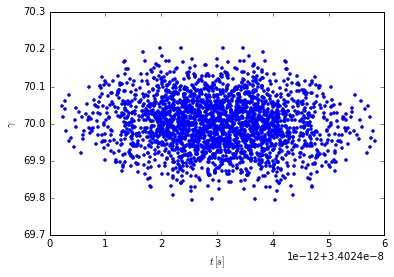

In [18]:
plt.plot(data_tp[:,0],data_tp[:,1],'.')
plt.xlabel('$t\,[s]$')
plt.ylabel('$\gamma$')

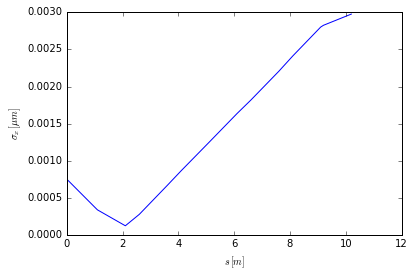

In [19]:
plt.plot(data_sSx[:,0],data_sSx[:,1],'-')
plt.ylabel('$\sigma_x\,[\mu m]$')
plt.xlabel('$s\,[m]$')

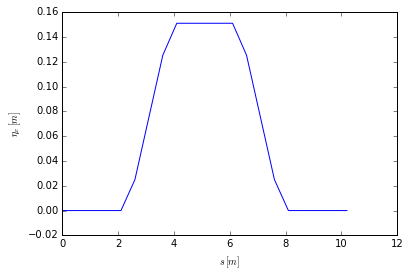

In [20]:
plt.plot(data_setax[:,0],data_setax[:,1],'-')
plt.ylabel('$\eta_{x}\,[m]$')
plt.xlabel('$s\,[m]$')

In [30]:
# Scan parameter: final Dx v.s. angle of B1
import numpy as np
dx = []
thetaArray = np.linspace(0.05,0.3,20)
for theta in thetaArray:
    eleb1.setConf({'angle':theta}, type = 'simu')
    latins = beamline.Lattice(latline_online.getAllConfig())
    latins.generateLatticeFile(latline_online.name, latfile)
    elesim.doSimulation()
    data = elesim.getOutput(file = 'test.twi', data = (['etax']))
    dx.append(data[-1])
dxArray = np.array(dx)

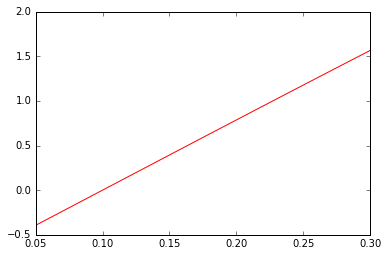

In [31]:
plt.plot(thetaArray, dxArray, 'r')